# Big Data Project - Twitter Sentiment Analysis - Data Preparation


## 1. Imports

In [0]:
# Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace, lower, trim, udf, pandas_udf, col, to_timestamp
from pyspark.sql.functions import udf

# Vader imports
#!pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# ML imports
from pyspark.ml.feature import NGram, VectorAssembler, StopWordsRemover, HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, ChiSqSelector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

##Visualization
import matplotlib.pyplot as plt

import pandas as pd


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2.Functions

In [0]:
# Function to mount bucket
def mount_s3_bucket(access_key, secret_key, bucket_name, mount_folder):
    ACCESS_KEY_ID = access_key
    SECRET_ACCESS_KEY = secret_key
    ENCODED_SECRET_KEY = SECRET_ACCESS_KEY.replace('/', '%2F')

    print ('Mounting', bucket_name)

    try:
    # Unmount the data in case it was already mounted.
        dbutils.fs.unmount('/mnt/%s' % mount_folder)

    except:
        # If it fails to unmount it most likely wasn't mounted in the first place
        print ('Directory not unmounted: ', mount_folder)

    finally:
        # Lastly, mount our bucket.
        dbutils.fs.mount('s3a://%s:%s@%s' % (ACCESS_KEY_ID, ENCODED_SECRET_KEY, bucket_name), '/mnt/%s' % mount_folder)
        print ('The bucket', bucket_name, 'was mounted to', mount_folder, '\n')

In [0]:
# Function to get sentiment
# Loops over text and  returns a pandas series of sentiments
def get_sentiment_udf(text_series: pd.Series) -> pd.Series:
    analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for text in text_series:
        sentiment = analyzer.polarity_scores(text)['compound']
        if sentiment > 0:
            sentiments.append('positive')
        elif sentiment < 0:
            sentiments.append('negative')
        else:
            sentiments.append('neutral')
    return pd.Series(sentiments)

## 3.Mounting S3 buckets


In [0]:
ACCESS_KEY = 'YOUR ACCESS KEY'
SECRET_ACCESS_KEY = 'YOUR SECRET KEY'

In [0]:
# Mounting WCD bucket with the data
mount_s3_bucket(ACCESS_KEY, SECRET_ACCESS_KEY, 'weclouddata/twitter/WorldCup/', 'project')

Mounting weclouddata/twitter/WorldCup/
Directory not unmounted:  project
The bucket weclouddata/twitter/WorldCup/ was mounted to project 



In [0]:
# Mounting own bucket to store data
mount_s3_bucket(ACCESS_KEY, SECRET_ACCESS_KEY, 'b17-masha/project/', 'storage')

Mounting b17-masha/project/
Directory not unmounted:  storage
The bucket b17-masha/project/ was mounted to storage 



## 4.Data Processing

### 4.1 Loading data

In [0]:
# Creating Spark Session
spark = SparkSession \
        .builder \
        .appName('Big Data Project') \
        .getOrCreate()
print('Session created')

sc = spark.sparkContext

Session created


In [0]:
# Creating Schema for our twitter data
wcSchema = StructType([
    StructField('id', LongType(), True),  
    StructField('user_name', StringType(), True),
    StructField('user_screen_name', StringType(), True),
    StructField('text', StringType(), True),
    StructField('followers_count', IntegerType(), True),
    StructField('location', StringType(), True),
    StructField('geo', StringType(), True),
    StructField('created_at', StringType(), True)  
])

In [0]:
# Loading Data - loading in the full dataset to filter rows that we are most interested in

file = '/mnt/project/*/*/*/*/*'

data = (spark.read                 
   .option('header', 'false')       
   .option('delimiter', '\t')
   .schema(wcSchema)      
   .csv(file)
)

### 4.2 Data Cleaning

For this project, tweets that are pure retweets will be removed to allow for more opportunities for free text

In [0]:
# Removing data that is purely retweets
data_0 = data.filter(col('text').like('RT%')==False)

In [0]:
# Limiting the dataframe to the first 1 million rows
data_1 = data_0.limit(1000000)

In [0]:
data_1.show(5)

+-------------------+--------------------+----------------+--------------------+---------------+-------------------+----+--------------------+
|                 id|           user_name|user_screen_name|                text|followers_count|           location| geo|          created_at|
+-------------------+--------------------+----------------+--------------------+---------------+-------------------+----+--------------------+
|1601642512845705216|ayub abdulahi max'ud|         ayub_ud|bayc world cup nf...|              3|               None|None|Sat Dec 10 18:18:...|
|1601642513080922112|  Watch Plug Wobs⚡🔌|         _varg76|    😂😂😂💀 Gbafest|            254|            Nigeria|None|Sat Dec 10 18:18:...|
|1601642513366155264|                  🙄|  thoughtsofdebs|Yayyyyyy if Niger...|            322|             London|None|Sat Dec 10 18:18:...|
|1601642511671230464|Better Odds Predi...|       Manaji111|I feel the pain f...|            111|               None|None|Sat Dec 10 18:18:...|
|1601

In [0]:
# dropping 'geo' due to lack of records
data_2 = data_1.drop('geo')

In [0]:
# dropping rows with null values in 'created_at' column to avoid data corruption when exporting
df = data_2.filter(col('created_at').isNull()==False)

In [0]:
# Converting 'created_at' column to timestamp
# Using legacy timestamp policy due to formatting
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')

# Converting 'created_at' to timestamp
df = data_2.withColumn('created', to_timestamp('created_at', 'EEE MMM dd HH:mm:ss Z yyyy')).drop('created_at')


### 4.3 Label Creation

Using Vader library as it is considered to be suitable for social media analysis. It's lexicon contains common emoticons as well, which will be useful in this analysis

In [0]:
# using pandas_udf provided the speediest processing time
get_sentiment_pandas_udf = pandas_udf(get_sentiment_udf, returnType=StringType())

# creating column 'sentiment' using user-defined function 'get sentiment'
df = df.withColumn('sentiment', get_sentiment_pandas_udf(col('text')))

In [0]:
# Repartitioning for better workload distribution
df = df.repartition(10)

## 5 EDA

### Visualizations

- There are 998362 rows of data after null values in date column had been dropped 
- Labels are somewhat balanced, with 'negative' being a minority class at 17.5% of all data
- it seems like the more followers users have the more likely it is for the to tweet positive tweets
- the rest of eda will be done in QuickSight


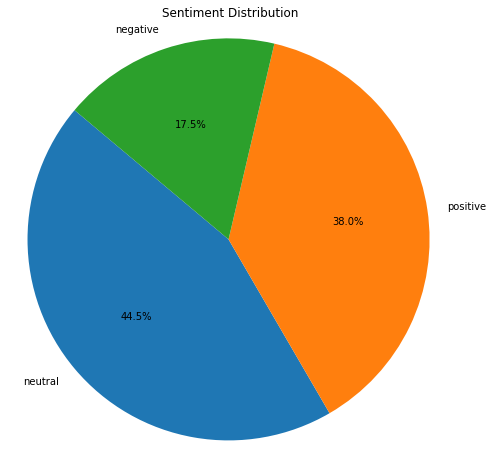

In [0]:
# Label distribution
sentiment_counts = df.groupBy('sentiment').agg(F.count('*').alias('count')).orderBy('count', ascending=False)
sentiment_counts_pd = sentiment_counts.toPandas()

# Extracting sentiment labels and counts
sentiments = sentiment_counts_pd['sentiment']
counts = sentiment_counts_pd['count']

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=sentiments, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  
plt.show()

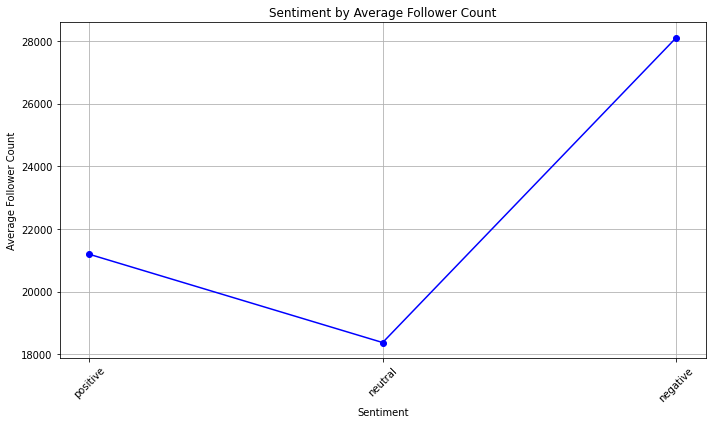

In [0]:
# sentiment by follower count
sentiment_follower_avg = df.groupBy('sentiment').agg(F.avg('followers_count').alias('avg_followers_count'))
sentiment_follower_avg_pd = sentiment_follower_avg.toPandas()

# Extract sentiment labels and average follower counts
sentiments = sentiment_follower_avg_pd['sentiment']
avg_followers_count = sentiment_follower_avg_pd['avg_followers_count']

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(sentiments, avg_followers_count, marker='o', linestyle='-', color='b')
plt.title('Sentiment by Average Follower Count')
plt.xlabel('Sentiment')
plt.ylabel('Average Follower Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

###  Saving cleaned data to tmp and s3

In [0]:
# Saving to tmp folder
projectOut = '/tmp/project/clean_data.csv'

(df.write                       
  .option('delimiter', '\t')  
  .option('header', 'true')
  .mode('overwrite')               
  .csv(projectOut)               
)

# Saving to mounted s3 bucket
s3_path = 'b17-masha/project'

(df.write 
  .format('csv') 
  .option('header', True) 
  .option('delimiter', '\t') 
  .mode('overwrite') 
  .save(f'/mnt/storage/{s3_path}')
)